<a href="https://colab.research.google.com/github/blankajarmoszko/stat_390/blob/kaylee/kaylee_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.regularizers import l1_l2
from keras.optimizers import Adam
import os

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Data Preprocessing

In [43]:
df = pd.read_csv('df_post_eda.csv')

In [44]:
# Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Make sure the data is sorted by Date
df.sort_values('Date', inplace=True)

# Set 'Date' column to index
df.set_index('Date', inplace=True)

In [45]:
# Group df by date
grouped = df.groupby(df.index).mean()
grouped.head()

<ipython-input-45-7b732df8a89d>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df.groupby(df.index).mean()


,MMWR_week,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_5Plus,Distributed_Per_100k_12Plus,Distributed_Per_100k_18Plus,...,Additional_Doses_Unk_Manuf,month,year,quarter,dayofyear,dayofmonth,weekofyear,holiday_season,vax_announcement,Additional_Doses_Vax_Pct_1_w_lag
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-03,44.0,1.663188e+07,818798.4375,6.480709e+06,9.242425e+06,89947.65625,146818.062500,152028.625000,167037.250000,186038.703125,...,249.390625,11.0,2021.0,4.0,307.0,3.0,44.0,0.0,0.0,10.367188
2021-11-10,45.0,1.714537e+07,836476.5625,6.642025e+06,9.666864e+06,0.00000,151460.531250,156997.781250,173446.453125,194278.203125,...,243.156250,11.0,2021.0,4.0,314.0,10.0,45.0,1.0,0.0,13.204688
2021-11-17,46.0,1.768302e+07,853621.8750,6.841471e+06,9.987929e+06,0.00000,155606.890625,161287.484375,178169.640625,199577.812500,...,272.468750,11.0,2021.0,4.0,321.0,17.0,46.0,0.0,1.0,15.907813
2021-11-24,47.0,1.811490e+07,874050.0000,6.908257e+06,1.033259e+07,0.00000,159194.265625,165021.546875,182287.593750,204172.562500,...,310.875000,11.0,2021.0,4.0,328.0,24.0,47.0,1.0,0.0,18.985937
2021-12-01,48.0,1.822699e+07,882312.5000,6.931029e+06,1.041364e+07,0.00000,160201.109375,166069.109375,183443.203125,205459.156250,...,332.187500,12.0,2021.0,4.0,335.0,1.0,48.0,0.0,1.0,20.384375


In [46]:
# Dropping Unncessary Columns

columns_to_drop = ['MMWR_week', 'Additional_Doses_Vax_Pct_1_w_lag'] #MMWR_week and weekofyear are same
# I am going to lag myself

# Drop the specified columns
df = grouped.drop(columns=columns_to_drop)

In [47]:
# Scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled.head(5)

,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_5Plus,Distributed_Per_100k_12Plus,Distributed_Per_100k_18Plus,Distributed_Per_100k_65Plus,...,Additional_Doses_Janssen,Additional_Doses_Unk_Manuf,month,year,quarter,dayofyear,dayofmonth,weekofyear,holiday_season,vax_announcement
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-03,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002677,0.909091,0.0,1.0,0.844011,0.066667,0.843137,0.0,0.0
2021-11-10,0.035505,0.083761,0.034580,0.045848,0.0,0.035776,0.035678,0.041371,0.048715,0.137336,...,0.085305,0.000000,0.909091,0.0,1.0,0.863510,0.300000,0.862745,1.0,0.0
2021-11-17,0.072682,0.164997,0.077333,0.080529,0.0,0.067730,0.066477,0.071859,0.080049,0.163318,...,0.164947,0.012586,0.909091,0.0,1.0,0.883008,0.533333,0.882353,0.0,1.0
2021-11-24,0.102544,0.261788,0.091649,0.117759,0.0,0.095375,0.093287,0.098441,0.107215,0.186691,...,0.248347,0.029076,0.909091,0.0,1.0,0.902507,0.766667,0.901961,1.0,0.0
2021-12-01,0.110295,0.300937,0.096530,0.126515,0.0,0.103134,0.100809,0.105900,0.114821,0.193132,...,0.307021,0.038226,1.000000,0.0,1.0,0.922006,0.000000,0.921569,0.0,1.0


In [48]:
categorical_columns = df_scaled.select_dtypes(include=['object']).columns
print(categorical_columns) #no categorical columns

Index([], dtype='object')


In [49]:
def process(df, columns_to_exclude=['holiday_season', 'vax_announcement']):
    columns_to_lag = [col for col in df.columns if col not in columns_to_exclude]
    lag1df = df[columns_to_lag].shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['Additional_Doses_Vax_Pct', 'holiday_season', 'vax_announcement']].join(lag1df)
    return df.fillna(0)
df = process(df_scaled)
df.head()

,Additional_Doses_Vax_Pct,holiday_season,vax_announcement,lag1_Distributed,lag1_Distributed_Janssen,lag1_Distributed_Moderna,lag1_Distributed_Pfizer,lag1_Distributed_Unk_Manuf,lag1_Dist_Per_100K,lag1_Distributed_Per_100k_5Plus,...,lag1_Additional_Doses_Moderna,lag1_Additional_Doses_Pfizer,lag1_Additional_Doses_Janssen,lag1_Additional_Doses_Unk_Manuf,lag1_month,lag1_year,lag1_quarter,lag1_dayofyear,lag1_dayofmonth,lag1_weekofyear
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-03,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
2021-11-10,0.070026,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.002677,0.909091,0.0,1.0,0.844011,0.066667,0.843137
2021-11-17,0.135949,0.0,1.0,0.035505,0.083761,0.034580,0.045848,0.0,0.035776,0.035678,...,0.075766,0.039331,0.085305,0.000000,0.909091,0.0,1.0,0.863510,0.300000,0.862745
2021-11-24,0.204748,1.0,0.0,0.072682,0.164997,0.077333,0.080529,0.0,0.067730,0.066477,...,0.147337,0.080079,0.164947,0.012586,0.909091,0.0,1.0,0.883008,0.533333,0.882353
2021-12-01,0.254180,0.0,1.0,0.102544,0.261788,0.091649,0.117759,0.0,0.095375,0.093287,...,0.224831,0.128386,0.248347,0.029076,0.909091,0.0,1.0,0.902507,0.766667,0.901961


In [50]:
na = df.isna().sum()
print(na[na>0]) #no null

Series([], dtype: int64)


In [65]:
def make_series(data):
    series=[]
    for i in range(len(data)-12):
        subdf=data[i:i+12]
        series.append( (subdf.index[-1], subdf['Additional_Doses_Vax_Pct'].values[-1], subdf.drop('Additional_Doses_Vax_Pct', axis=1).values))
    return series
series=make_series(df)
print(series[0][0],series[0][1].shape,series[0][2].shape)

2022-01-19 00:00:00 () (12, 67)


In [66]:
print(len(series))

68


In [67]:
train=series[:-20]
test=series[-20:]

In [69]:
# Prepare data for LSTM
X_train = np.array([x[2] for x in train])
y_train = np.array([x[1] for x in train])
X_test = np.array([x[2] for x in test])
y_test = np.array([x[1] for x in test])

In [71]:
# Base Model
inputs = keras.layers.Input(shape=(12,67))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')


In [73]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=True)

Epoch 1/100
2/2 [==============================] - 3s 16ms/step - loss: 1.2453
Epoch 2/100
2/2 [==============================] - 0s 12ms/step - loss: 0.7723
Epoch 3/100
2/2 [==============================] - 0s 11ms/step - loss: 0.1096
Epoch 4/100
2/2 [==============================] - 0s 12ms/step - loss: 0.3669
Epoch 5/100
2/2 [==============================] - 0s 16ms/step - loss: 0.2886
Epoch 6/100
2/2 [==============================] - 0s 12ms/step - loss: 0.1300
Epoch 7/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0317
Epoch 8/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0025
Epoch 9/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0161
Epoch 10/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0345
Epoch 11/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0395
Epoch 12/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0307
Epoch 13/100
2/2 [==============================]

In [76]:
# Generate predictions
train_pred = model.predict(X_train).flatten()
test_pred = model.predict(X_test).flatten()

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

1/1 [==============================] - 0s 42ms/step
Test RMSE: 0.012198569569705012
Train RMSE: 0.05339023367032229


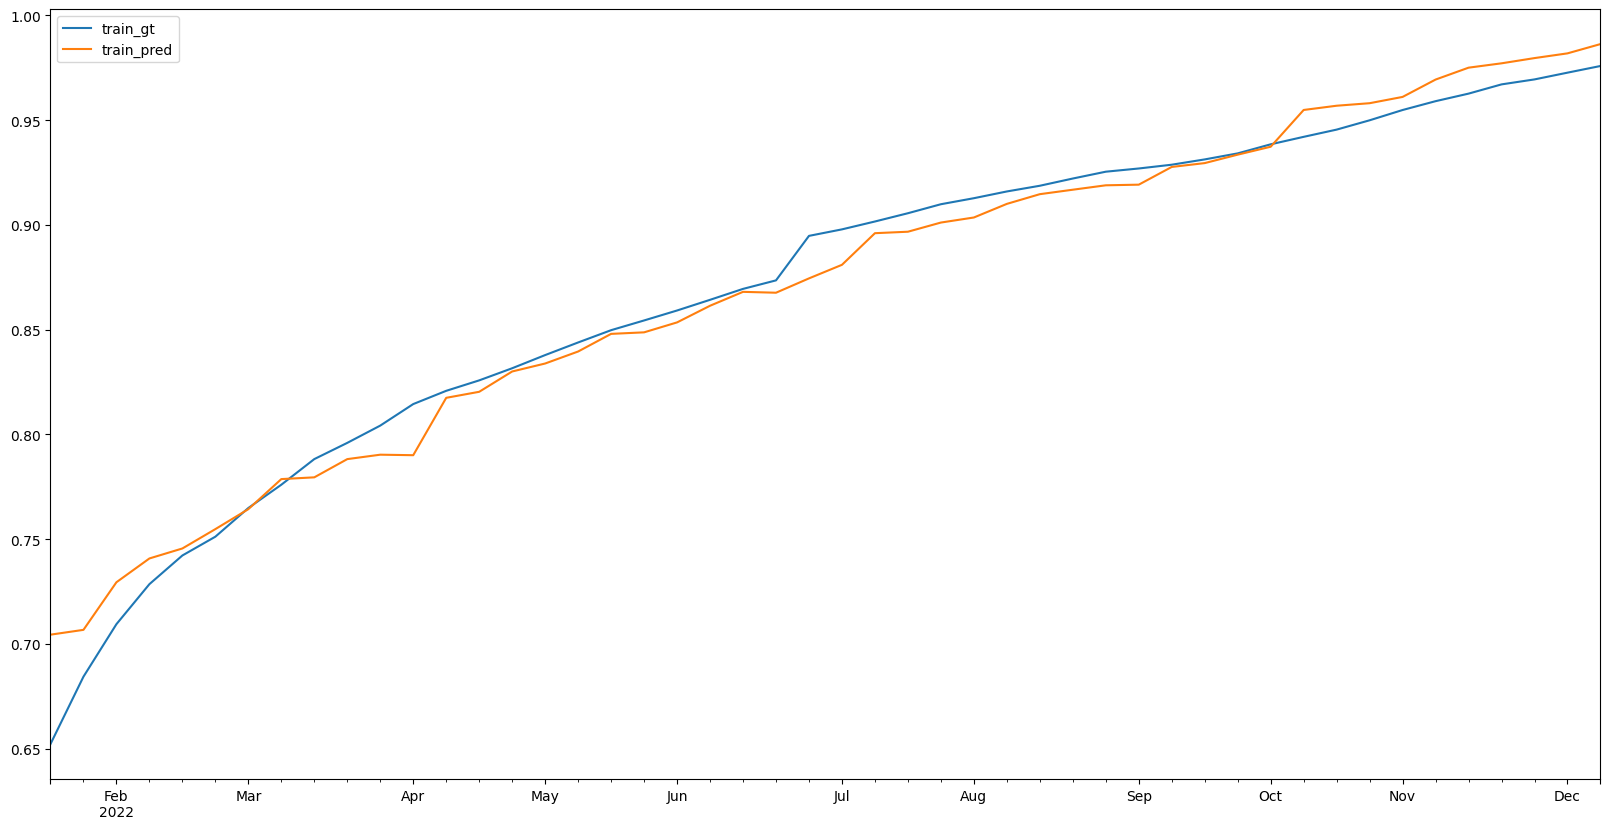

In [79]:
train_indices = [x[0] for x in train]
train_gt = pd.DataFrame(y_train, columns=['y'], index=train_indices)
train_pred = pd.DataFrame(train_pred, columns=['yhat'], index=train_indices)
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

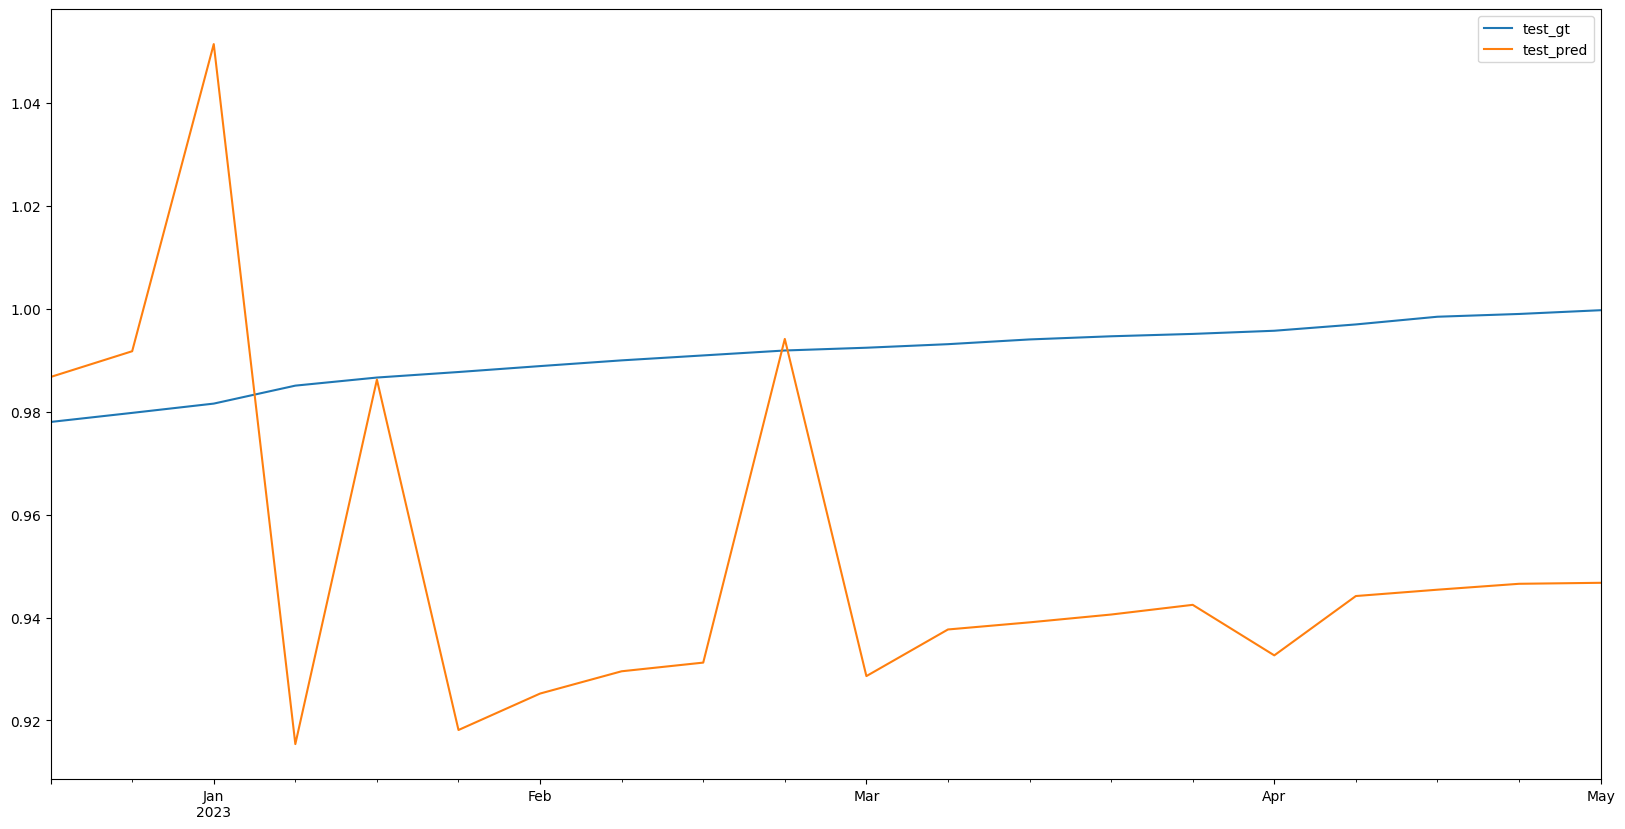

In [80]:
test_indices = [x[0] for x in test]
test_gt = pd.DataFrame(y_test, columns=['y'], index=test_indices)
test_pred = pd.DataFrame(test_pred, columns=['yhat'], index=test_indices)
pd.concat([test_gt, test_pred], axis=1).plot(figsize=(20,10))
plt.legend(['test_gt', 'test_pred'])

In [ ]:
# initial is overfitting on the training data

In [81]:
# Add dropout
model = keras.Sequential()
model.add(keras.layers.LSTM(32, input_shape=(12,67)))
model.add(keras.layers.Dropout(0.2))  # Dropout layer to reduce overfitting
model.add(keras.layers.Dense(1))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=True)

In [82]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=True)

Epoch 1/100
2/2 [==============================] - 3s 14ms/step - loss: 0.9107
Epoch 2/100
2/2 [==============================] - 0s 12ms/step - loss: 0.4309
Epoch 3/100
2/2 [==============================] - 0s 11ms/step - loss: 0.2596
Epoch 4/100
2/2 [==============================] - 0s 16ms/step - loss: 0.4447
Epoch 5/100
2/2 [==============================] - 0s 12ms/step - loss: 0.2327
Epoch 6/100
2/2 [==============================] - 0s 11ms/step - loss: 0.1178
Epoch 7/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0292
Epoch 8/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0409
Epoch 9/100
2/2 [==============================] - 0s 14ms/step - loss: 0.0684
Epoch 10/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0774
Epoch 11/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0697
Epoch 12/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0519
Epoch 13/100
2/2 [==============================]

In [84]:
# Generate predictions
train_pred = model.predict(X_train).flatten()
test_pred = model.predict(X_test).flatten()

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}") #made overfitting worse

1/1 [==============================] - 0s 57ms/step
Train RMSE: 0.03698503595676343
Test RMSE: 0.10450049825599939


Number of Units (Neurons):
Parameter: units in the LSTM layer.
Description: The number of LSTM units (neurons) in the layer. A smaller number may reduce overfitting, but it should be chosen carefully to capture the complexity of the data.

Dropout:
Parameter: dropout in the Dropout layer.
Description: Dropout is a regularization technique where a proportion of randomly selected neurons are ignored during training. It helps prevent overfitting by promoting a more robust network.
python
model.add(keras.layers.LSTM(units, input_shape=input_shape))
model.add(keras.layers.Dropout(dropout_rate))

Learning Rate:
Parameter: learning_rate in the optimizer.
Description: Learning rate controls the step size during optimization. A high learning rate may lead to overshooting, while a low learning rate may result in slow convergence.
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)


Weight Regularization (L2 or L1):
Parameter: kernel_regularizer in the LSTM layer.
Description: Apply L2 or L1 regularization on the weights to prevent them from becoming too large.
model.add(keras.layers.LSTM(units, input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(weight_decay)))


Early Stopping:
Callback: EarlyStopping callback.
Description: Monitor a validation metric and stop training early if the metric does not improve for a certain number of epochs.
python

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Then, during the fit phase:
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[early_stopping])



In [93]:
# neurons, dropout, learning_rate, l2, l1, early stopping
import numpy as np
from tensorflow import keras
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Define the Keras LSTM model function
def create_lstm_model(units=32, dropout_rate=0.2, learning_rate=0.01, l2=0.01, l1=0.01, input_shape=(12, 67)):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units, input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(l2), activity_regularizer=keras.regularizers.l1(l1)))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(1))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Define hyperparameter values for the for-loop grid search
units_values = [16, 32, 64]
dropout_values = [0.2, 0.3]
learning_rate_values = [0.01, 0.001]
l2_values = [0.01, 0.001, 0.0001]
l1_values = [0.01, 0.001, 0.0001]

# Create TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

best_rmse = float('inf')  # Initialize with a large value
best_params = {}

# For-loop grid search
for units in units_values:
    for dropout in dropout_values:
        for learning_rate in learning_rate_values:
            for l2 in l2_values:
                for l1 in l1_values:
                    # Create the KerasRegressor
                    lstm_model = create_lstm_model(units=units, dropout_rate=dropout, learning_rate=learning_rate, l2=l2, l1=l1)

                    # Track performance using cross-validation
                    rmse_values = []
                    for train_index, val_index in tscv.split(X_train):
                        x_train_split, x_val_split = X_train[train_index], X_train[val_index]
                        y_train_split, y_val_split = y_train[train_index], y_train[val_index]

                        lstm_model.fit(x_train_split, y_train_split,
                                       validation_data=(x_val_split, y_val_split), epochs=100, batch_size=32, verbose=0)

                        y_pred_val = lstm_model.predict(x_val_split)
                        rmse_val = np.sqrt(mean_squared_error(y_val_split, y_pred_val))
                        rmse_values.append(rmse_val)

                    # Calculate average RMSE over cross-validation folds
                    avg_rmse = np.mean(rmse_values)

                    # Check if the current set of hyperparameters gives a better result
                    if avg_rmse < best_rmse:
                        best_rmse = avg_rmse
                        best_params = {
                            'units': units,
                            'dropout': dropout,
                            'learning_rate': learning_rate,
                            'l2': l2,
                            'l1': l1
                        }

# Print the best parameters
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

1/1 [==============================] - 0s 23ms/step
Best Parameters: {'units': 16, 'dropout': 0.2, 'learning_rate': 0.01, 'l2': 0.01, 'l1': 0.0001}
Best RMSE: 0.01474362832163966


In [104]:
model = keras.Sequential()
model.add(keras.layers.LSTM(16, input_shape=(12,67),
                            kernel_regularizer=keras.regularizers.l2(0.01), activity_regularizer=keras.regularizers.l1(0.0001)))
model.add(keras.layers.Dropout(0.2))  # Dropout layer to reduce overfitting
model.add(keras.layers.Dense(1))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=True)

# Generate predictions
train_pred = model.predict(X_train).flatten()
test_pred = model.predict(X_test).flatten()

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Epoch 1/100
2/2 [==============================] - 5s 13ms/step - loss: 1.1914
Epoch 2/100
2/2 [==============================] - 0s 11ms/step - loss: 1.1376
Epoch 3/100
2/2 [==============================] - 0s 12ms/step - loss: 0.6922
Epoch 4/100
2/2 [==============================] - 0s 14ms/step - loss: 0.7108
Epoch 5/100
2/2 [==============================] - 0s 14ms/step - loss: 0.7106
Epoch 6/100
2/2 [==============================] - 0s 16ms/step - loss: 0.6342
Epoch 7/100
2/2 [==============================] - 0s 11ms/step - loss: 0.5655
Epoch 8/100
2/2 [==============================] - 0s 11ms/step - loss: 0.5114
Epoch 9/100
2/2 [==============================] - 0s 16ms/step - loss: 0.5132
Epoch 10/100
2/2 [==============================] - 0s 14ms/step - loss: 0.4959
Epoch 11/100
2/2 [==============================] - 0s 14ms/step - loss: 0.4345
Epoch 12/100
2/2 [==============================] - 0s 18ms/step - loss: 0.4044
Epoch 13/100
2/2 [==============================]

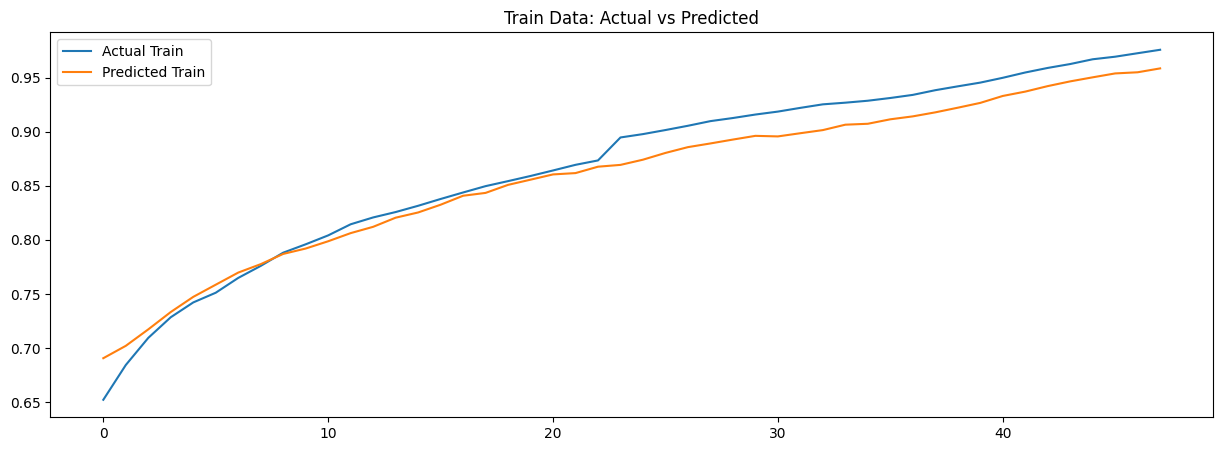

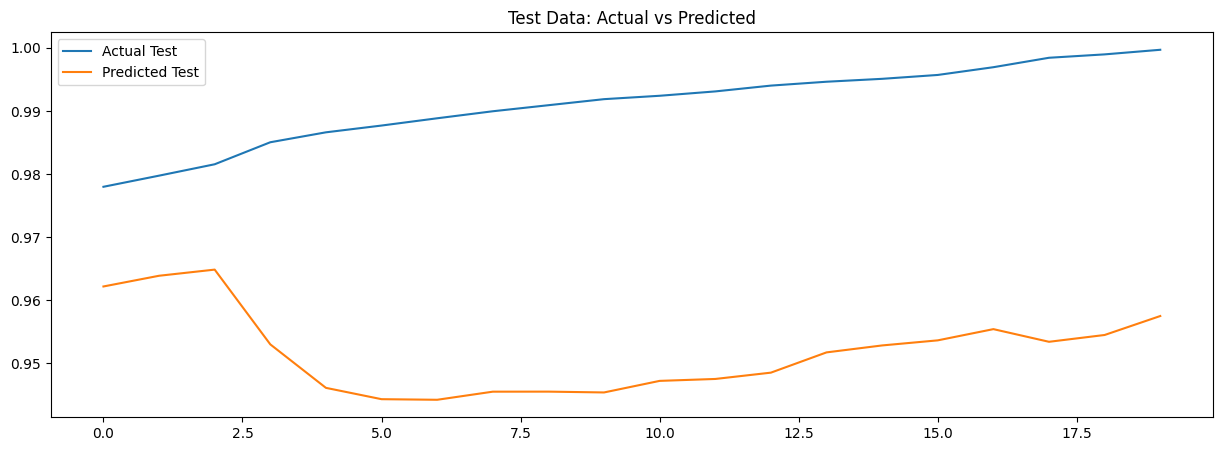

In [105]:
# Plotting train predictions and actual values
plt.figure(figsize=(15, 5))
plt.plot(range(len(y_train)), y_train, label='Actual Train')
plt.plot(range(len(train_pred)), train_pred, label='Predicted Train')
plt.title('Train Data: Actual vs Predicted')
plt.legend()
plt.show()

# Plotting test predictions and actual values
plt.figure(figsize=(15, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Test')
plt.plot(range(len(test_pred)), test_pred, label='Predicted Test')
plt.title('Test Data: Actual vs Predicted')
plt.legend()
plt.show()

In [101]:
import numpy as np
from tensorflow import keras
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Define the Keras LSTM model function
def create_lstm_model(units=32, dropout_rate=0.2, learning_rate=0.01, l2=0.01, l1=0.01, clip_value=None, patience=None, input_shape=(12, 67)):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units, input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(l2), activity_regularizer=keras.regularizers.l1(l1)))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(1))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=clip_value)  # Use clip_value for gradient clipping
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    return model, early_stopping

# Define hyperparameter values for the for-loop grid search
units_values = [16, 32, 64]
dropout_values = [0.2, 0.3]
learning_rate_values = [0.01]
l2_values = [0.01, 0.001]
l1_values = [0.001, 0.0001]
clip_values = [1.0, 0.5, None]  # Gradient clipping values
patience_values = [10, 15, 20]  # Early stopping patience values

# Create TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

best_rmse = float('inf')  # Initialize with a large value
best_params = {}

# For-loop grid search
for units in units_values:
    for dropout in dropout_values:
        for learning_rate in learning_rate_values:
            for l2 in l2_values:
                for l1 in l1_values:
                    for clip_value in clip_values:
                        for patience_value in patience_values:
                            # Create the KerasRegressor
                            lstm_model, early_stopping = create_lstm_model(units=units, dropout_rate=dropout, learning_rate=learning_rate,
                                                                            l2=l2, l1=l1, clip_value=clip_value, patience=patience_value)

                            # Track performance using cross-validation
                            rmse_values = []
                            for train_index, val_index in tscv.split(X_train):
                                x_train_split, x_val_split = X_train[train_index], X_train[val_index]
                                y_train_split, y_val_split = y_train[train_index], y_train[val_index]

                                history = lstm_model.fit(x_train_split, y_train_split,
                                               validation_data=(x_val_split, y_val_split), epochs=100, batch_size=32, verbose=0,
                                               callbacks=[early_stopping])

                                y_pred_val = lstm_model.predict(x_val_split)
                                rmse_val = np.sqrt(mean_squared_error(y_val_split, y_pred_val))
                                rmse_values.append(rmse_val)

                            # Calculate average RMSE over cross-validation folds
                            avg_rmse = np.mean(rmse_values)

                            # Check if the current set of hyperparameters gives a better result
                            if avg_rmse < best_rmse:
                                best_rmse = avg_rmse
                                best_params = {
                                    'units': units,
                                    'dropout': dropout,
                                    'learning_rate': learning_rate,
                                    'l2': l2,
                                    'l1': l1,
                                    'clip_value': clip_value,
                                    'patience': patience_value
                                }

# Print the best parameters
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

1/1 [==============================] - 0s 32ms/step
Best Parameters: {'units': 16, 'dropout': 0.2, 'learning_rate': 0.01, 'l2': 0.01, 'l1': 0.0001, 'clip_value': 0.5, 'patience': 15}
Best RMSE: 0.010073038350753039


In [106]:
model = keras.Sequential()
model.add(keras.layers.LSTM(16, input_shape=(12,67),
                            kernel_regularizer=keras.regularizers.l2(0.01), activity_regularizer=keras.regularizers.l1(0.0001),
                            ))
model.add(keras.layers.Dropout(0.2))  # Dropout layer to reduce overfitting
model.add(keras.layers.Dense(1))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01, clipvalue=0.5), loss='mean_squared_error')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=False)

# Generate predictions
train_pred = model.predict(X_train).flatten()
test_pred = model.predict(X_test).flatten()

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Epoch 1/100
2/2 [==============================] - 5s 20ms/step - loss: 1.2301
Epoch 2/100
2/2 [==============================] - 0s 29ms/step - loss: 0.8089
Epoch 3/100
2/2 [==============================] - 0s 21ms/step - loss: 0.6560
Epoch 4/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6508
Epoch 5/100
2/2 [==============================] - 0s 21ms/step - loss: 0.5644
Epoch 6/100
2/2 [==============================] - 0s 18ms/step - loss: 0.5108
Epoch 7/100
2/2 [==============================] - 0s 19ms/step - loss: 0.4799
Epoch 8/100
2/2 [==============================] - 0s 30ms/step - loss: 0.4503
Epoch 9/100
2/2 [==============================] - 0s 18ms/step - loss: 0.4100
Epoch 10/100
2/2 [==============================] - 0s 19ms/step - loss: 0.3685
Epoch 11/100
2/2 [==============================] - 0s 29ms/step - loss: 0.3350
Epoch 12/100
2/2 [==============================] - 0s 15ms/step - loss: 0.3084
Epoch 13/100
2/2 [==============================]

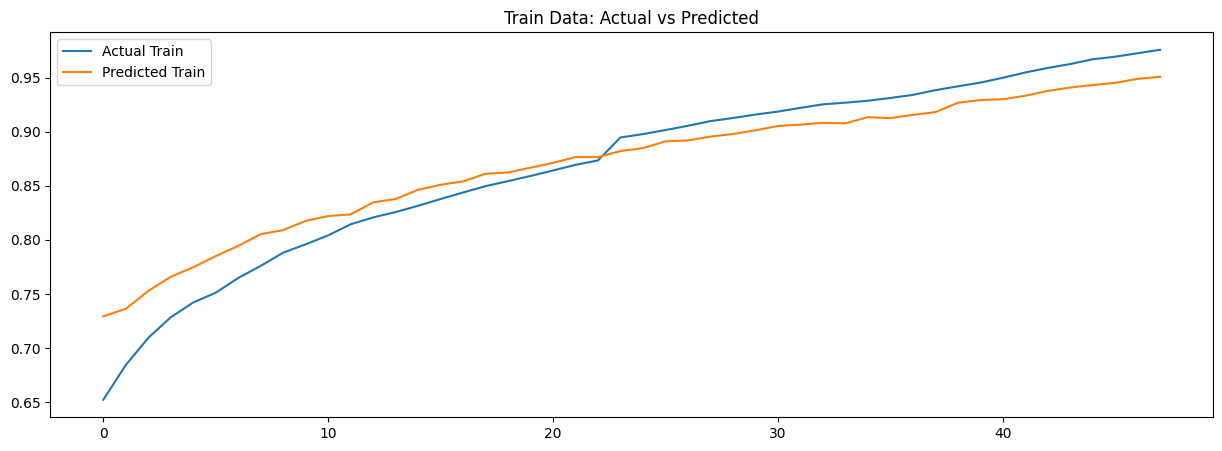

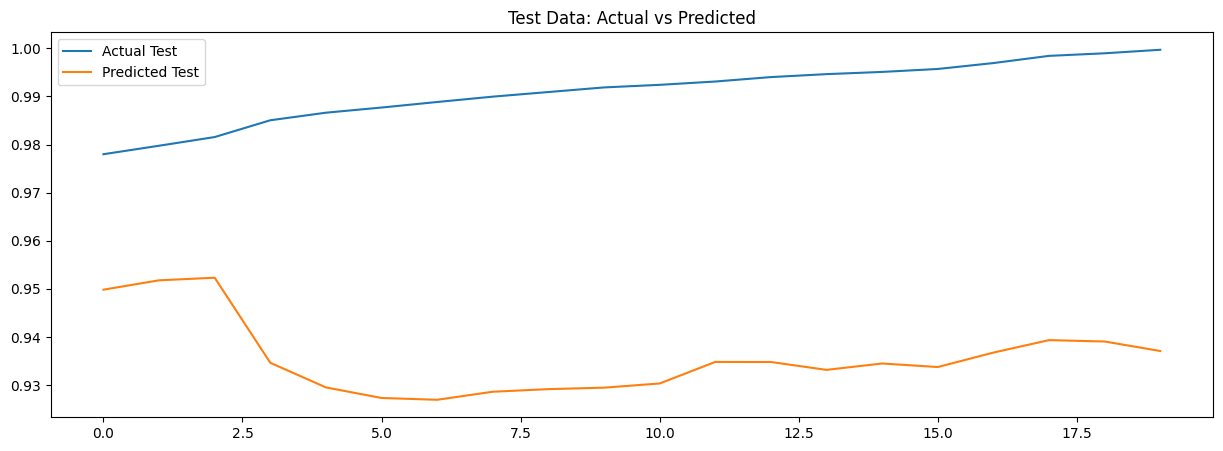

In [103]:
# Plotting train predictions and actual values
plt.figure(figsize=(15, 5))
plt.plot(range(len(y_train)), y_train, label='Actual Train')
plt.plot(range(len(train_pred)), train_pred, label='Predicted Train')
plt.title('Train Data: Actual vs Predicted')
plt.legend()
plt.show()

# Plotting test predictions and actual values
plt.figure(figsize=(15, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Test')
plt.plot(range(len(test_pred)), test_pred, label='Predicted Test')
plt.title('Test Data: Actual vs Predicted')
plt.legend()
plt.show()